# Libraries

In [1]:
import glob
import cv2
import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import kagglehub

In [4]:
import os
from collections import Counter
import random
import re
import json
import pickle

In [5]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras.applications import ResNet50

# Constants

In [6]:
IMG_W = 256
IMG_H = 256

WEIGHTS_PATH = r'weights_check_point'

# G Model

V1

In [7]:
def build_generator_v1():

    def SE_Block(input_tensor, reduction=16):
        filters = input_tensor.shape[-1]
        se = GlobalAveragePooling2D()(input_tensor)
        se = Dense(filters // reduction, activation='relu')(se)
        se = Dense(filters, activation='sigmoid')(se)
        se = Reshape((1, 1, filters))(se)
        return Multiply()([input_tensor, se])


    def ResidualBlock(x, filters):
        shortcut = x
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Conv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([shortcut, x])
        x = LeakyReLU(0.2)(x)
        return x


    inputs = Input((IMG_W, IMG_H, 1))

    # Encoder
    e1 = Conv2D(64, 4, strides=2, padding='same')(inputs)
    e1 = LeakyReLU(0.2)(e1)

    e2 = Conv2D(128, 4, strides=2, padding='same')(e1)
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU(0.2)(e2)

    e3 = Conv2D(256, 4, strides=2, padding='same')(e2)
    e3 = BatchNormalization()(e3)
    e3 = LeakyReLU(0.2)(e3)

    e4 = Conv2D(512, 4, strides=2, padding='same')(e3)
    e4 = BatchNormalization()(e4)
    e4 = LeakyReLU(0.2)(e4)

    # Bottleneck + Residuals + SE block
    b = Conv2D(1024, 4, strides=2, padding='same')(e4)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    for _ in range(3):
        b = ResidualBlock(b, 1024)
    b = SE_Block(b)

    # Decoder
    d1 = Conv2DTranspose(512, 4, strides=2, padding='same')(b)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.5)(d1)
    d1 = Activation('relu')(d1)
    d1 = Concatenate()([d1, e4])

    d2 = Conv2DTranspose(256, 4, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.5)(d2)
    d2 = Activation('relu')(d2)
    d2 = Concatenate()([d2, e3])

    d3 = Conv2DTranspose(128, 4, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    d3 = Concatenate()([d3, e2])

    d4 = Conv2DTranspose(64, 4, strides=2, padding='same')(d3)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    d4 = Concatenate()([d4, e1])

    d5 = Conv2DTranspose(64, 4, strides=2, padding='same')(d4)
    d5 = BatchNormalization()(d5)
    d5 = Activation('relu')(d5)

    outputs = Conv2D(3, 1, activation='tanh')(d5)

    gen_model = Model(inputs, outputs)

    return gen_model

V2

In [8]:
def build_generator_v2(img_w, img_h):
    """Improved generator with better color handling"""


    def SE_Block(input_tensor, reduction=16):
        """Squeeze-and-Excitation block"""
        filters = input_tensor.shape[-1]
        se = GlobalAveragePooling2D()(input_tensor)
        se = Dense(filters // reduction, activation='relu')(se)
        se = Dense(filters, activation='sigmoid')(se)
        se = Reshape((1, 1, filters))(se)
        return Multiply()([input_tensor, se])

    def ResidualBlock(x, filters):
        """Residual block with batch normalization"""
        shortcut = x
        x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = LeakyReLU(0.2)(x)
        x = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = Add()([shortcut, x])
        x = LeakyReLU(0.2)(x)
        return x

    inputs = Input((img_h, img_w, 2))
    
    # Encoder with better initialization
    e1 = Conv2D(64, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_1')(inputs)
    e1 = LeakyReLU(0.2)(e1)
    
    e2 = Conv2D(128, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_2')(e1)
    e2 = BatchNormalization(momentum=0.9)(e2)
    e2 = LeakyReLU(0.2)(e2)
    
    e3 = Conv2D(256, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_3')(e2)
    e3 = BatchNormalization(momentum=0.9)(e3)
    e3 = LeakyReLU(0.2)(e3)
    
    e4 = Conv2D(512, 4, strides=2, padding='same', 
                kernel_initializer='he_normal', name='enc_4')(e3)
    e4 = BatchNormalization(momentum=0.9)(e4)
    e4 = LeakyReLU(0.2)(e4)
    
    # Bottleneck
    b = Conv2D(1024, 4, strides=2, padding='same', 
               kernel_initializer='he_normal', name='bottleneck')(e4)
    b = BatchNormalization(momentum=0.9)(b)
    b = Activation('relu')(b)
    
    # Fewer residual blocks to prevent over-processing
    for i in range(2):
        b = ResidualBlock(b, 1024)
    
    b = SE_Block(b)
    
    # Decoder
    d1 = Conv2DTranspose(512, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_1')(b)
    d1 = BatchNormalization(momentum=0.9)(d1)
    d1 = Dropout(0.2)(d1)  # Reduced dropout
    d1 = Activation('relu')(d1)
    d1 = Concatenate()([d1, e4])
    
    d2 = Conv2DTranspose(256, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_2')(d1)
    d2 = BatchNormalization(momentum=0.9)(d2)
    d2 = Dropout(0.2)(d2)
    d2 = Activation('relu')(d2)
    d2 = Concatenate()([d2, e3])
    
    d3 = Conv2DTranspose(128, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_3')(d2)
    d3 = BatchNormalization(momentum=0.9)(d3)
    d3 = Activation('relu')(d3)
    d3 = Concatenate()([d3, e2])
    
    d4 = Conv2DTranspose(64, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_4')(d3)
    d4 = BatchNormalization(momentum=0.9)(d4)
    d4 = Activation('relu')(d4)
    d4 = Concatenate()([d4, e1])
    
    d5 = Conv2DTranspose(32, 4, strides=2, padding='same', 
                        kernel_initializer='he_normal', name='dec_5')(d4)
    d5 = BatchNormalization(momentum=0.9)(d5)
    d5 = Activation('relu')(d5)
    
    # IMPROVED: Dual-branch output for better color control
    # Structure branch (main details)
    structure = Conv2D(3, 3, padding='same', activation='tanh', 
                      kernel_initializer='glorot_normal', name='structure_out')(d5)
    
    # Color refinement branch (subtle color adjustments)
    color_refine = Conv2D(3, 1, padding='same', activation='tanh', 
                         kernel_initializer='zeros', name='color_out')(d5)
    
    # Combine: favor structure but allow color refinement
    outputs = Add(name='final_output')([0.8 * structure, 0.2 * color_refine])
    
    return Model(inputs, outputs, name='generator')

In [9]:
generators_list = []

for subfolder_name in os.listdir(WEIGHTS_PATH):
    need_noise = "noisy" in subfolder_name

    if need_noise:
        g_weights_i = os.path.join(WEIGHTS_PATH, subfolder_name, 'noisy_gan_v2_generator.weights.h5')

        gen_model_i = build_generator_v2(IMG_W, IMG_H)
        gen_model_i.load_weights(g_weights_i)

    else:
        g_weights_i = os.path.join(WEIGHTS_PATH, subfolder_name, 'gan_deep_v1_generator.weights.h5')

        gen_model_i = build_generator_v1()
        gen_model_i.load_weights(g_weights_i)

    print(f'Loaded weights from {g_weights_i}')

    generators_list.append((gen_model_i, need_noise ))

Loaded weights from weights_check_point\noisy_trier_1\noisy_gan_v2_generator.weights.h5
Loaded weights from weights_check_point\trier_1\gan_deep_v1_generator.weights.h5
Loaded weights from weights_check_point\trier_2\gan_deep_v1_generator.weights.h5
Loaded weights from weights_check_point\trier_3\gan_deep_v1_generator.weights.h5
Loaded weights from weights_check_point\trier_4\gan_deep_v1_generator.weights.h5
Loaded weights from weights_check_point\trier_5\gan_deep_v1_generator.weights.h5


# Load Val dataset

In [10]:
# Load Val dataset
val_images = glob.glob(os.path.join('val', '*.jpg'))
np.random.shuffle(val_images)
print(f'Found {len(val_images)} validation images.')

Found 200 validation images.


In [11]:
X = []
y_truth = []

for img_path in tqdm.tqdm(val_images):
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_W * 2, IMG_H ))

    x_i = img[:, :IMG_W]
    y_i = img[:, IMG_W:]

    x_i = cv2.cvtColor(x_i, cv2.COLOR_RGB2GRAY)

    x_i = (x_i / 255.0) * 2.0 - 1.0
    y_i = (y_i / 255.0) * 2.0 - 1.0

    X.append(x_i)
    y_truth.append(y_i)

X = np.array(X)
y_truth = np.array(y_truth)

100%|██████████| 200/200 [00:02<00:00, 92.49it/s]


# Test All Model Weights

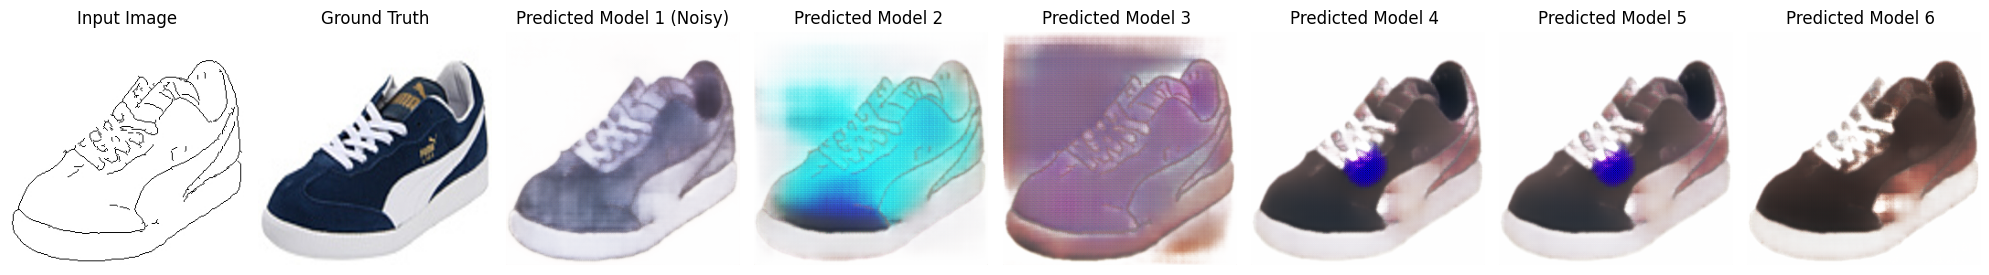

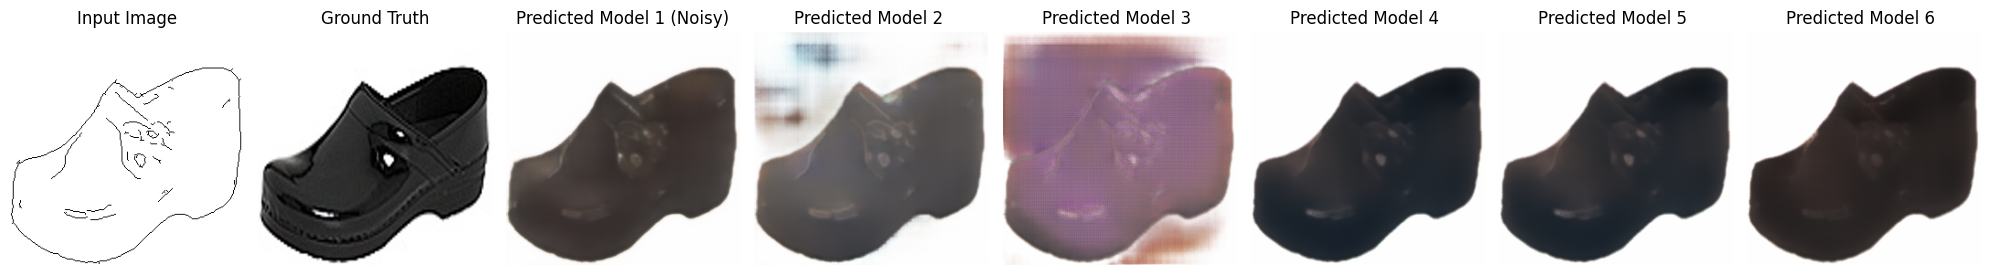

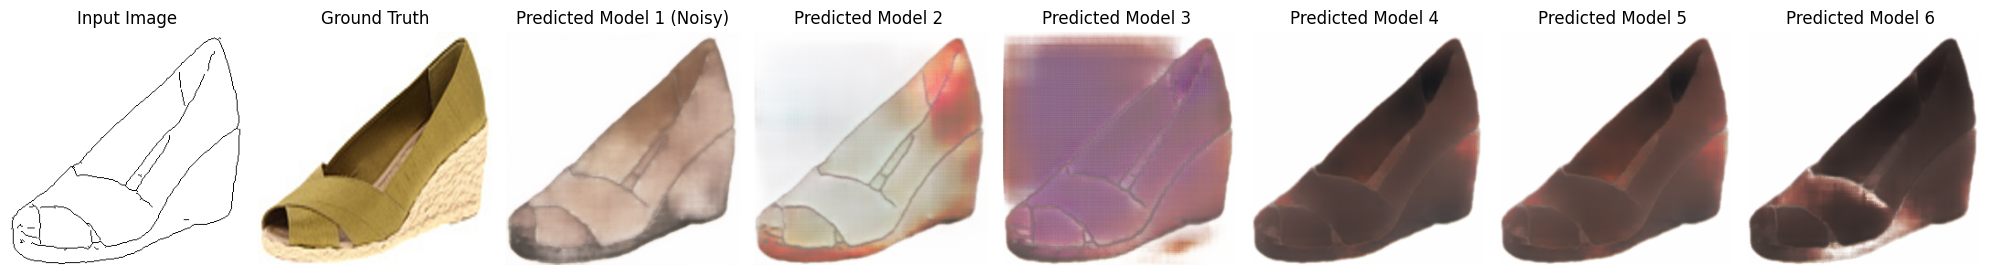

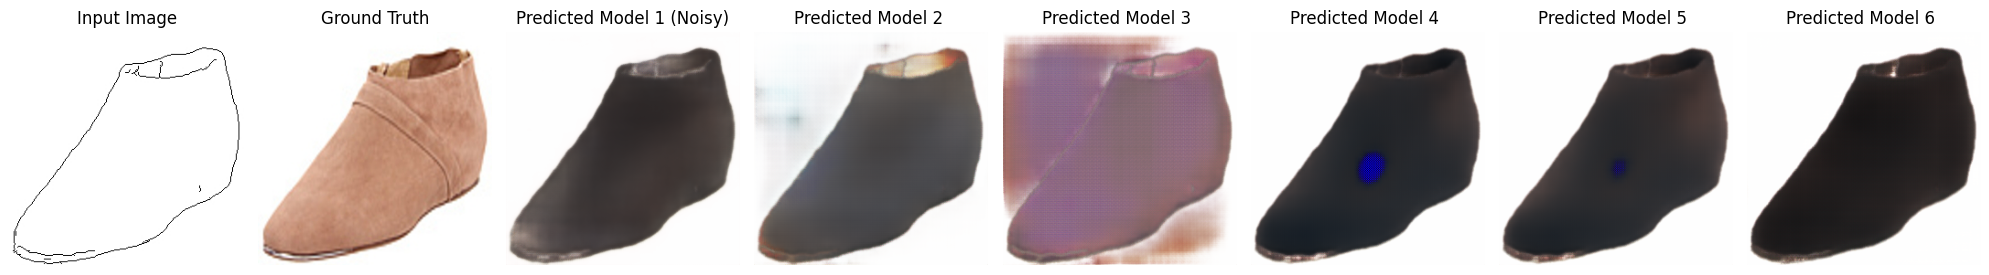

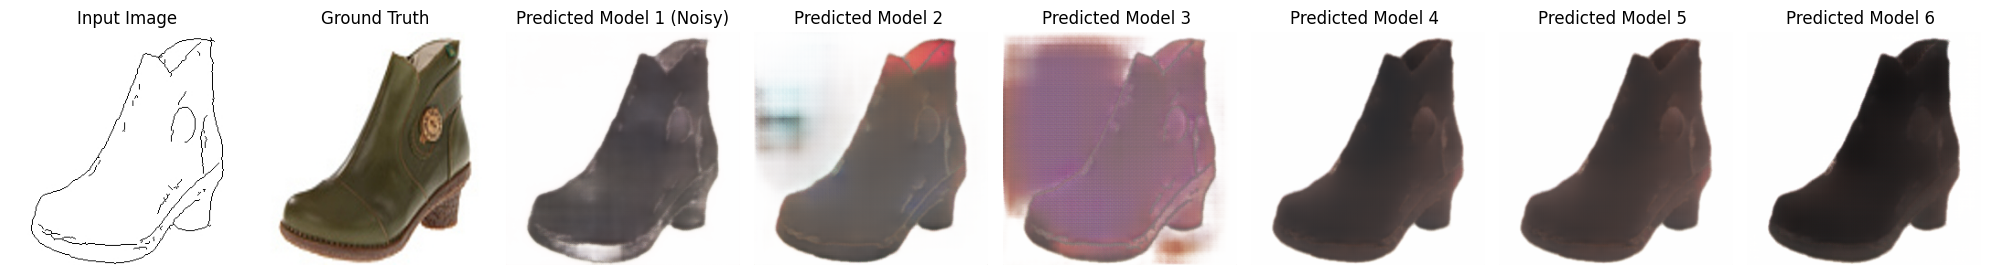

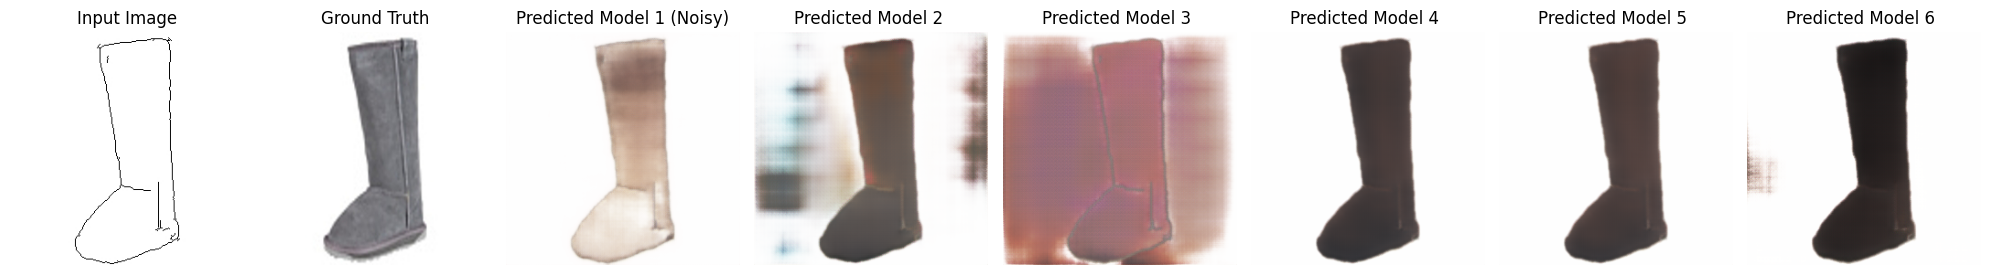

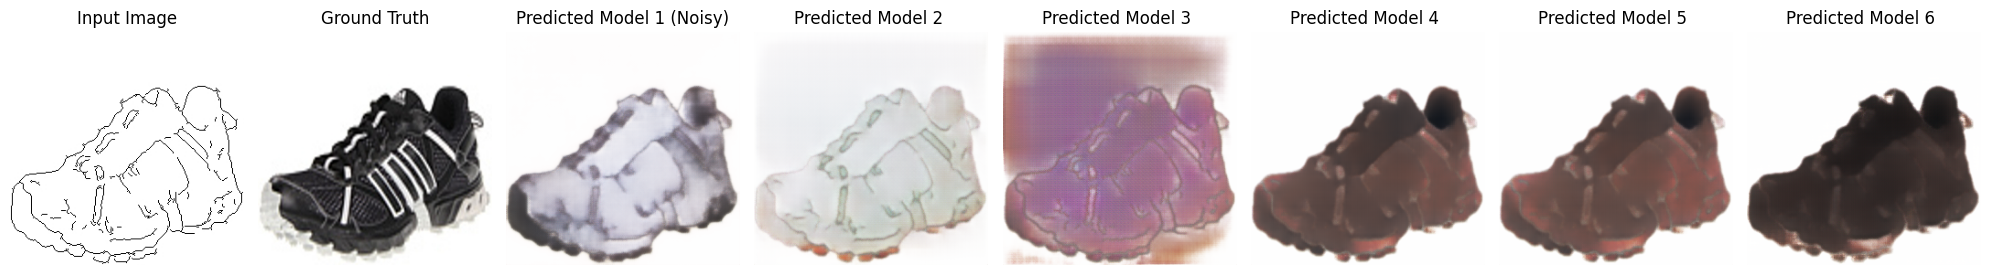

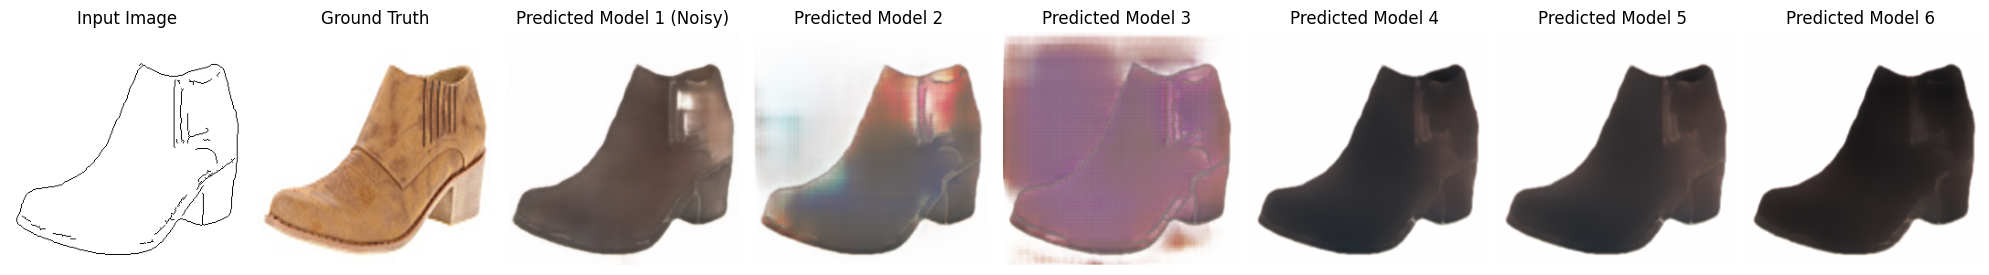

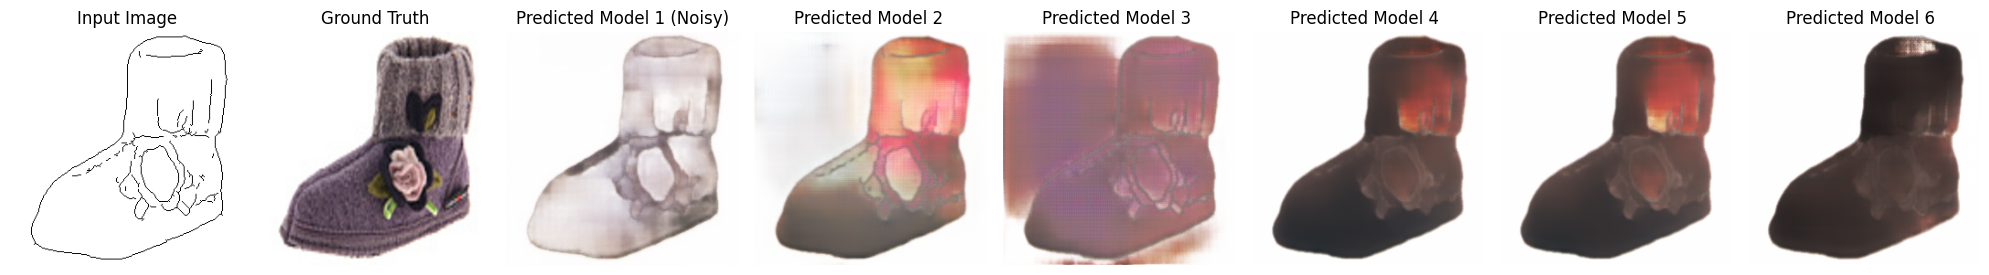

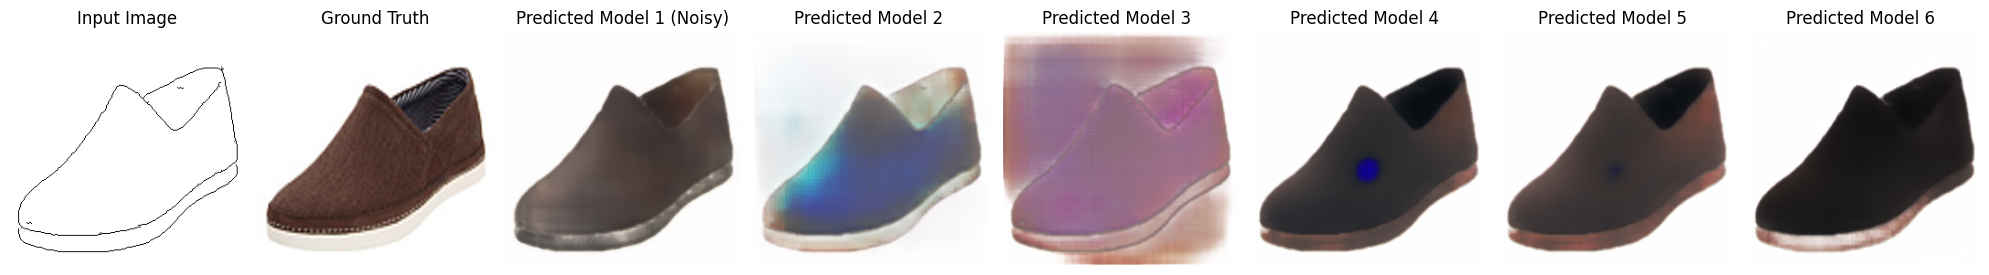

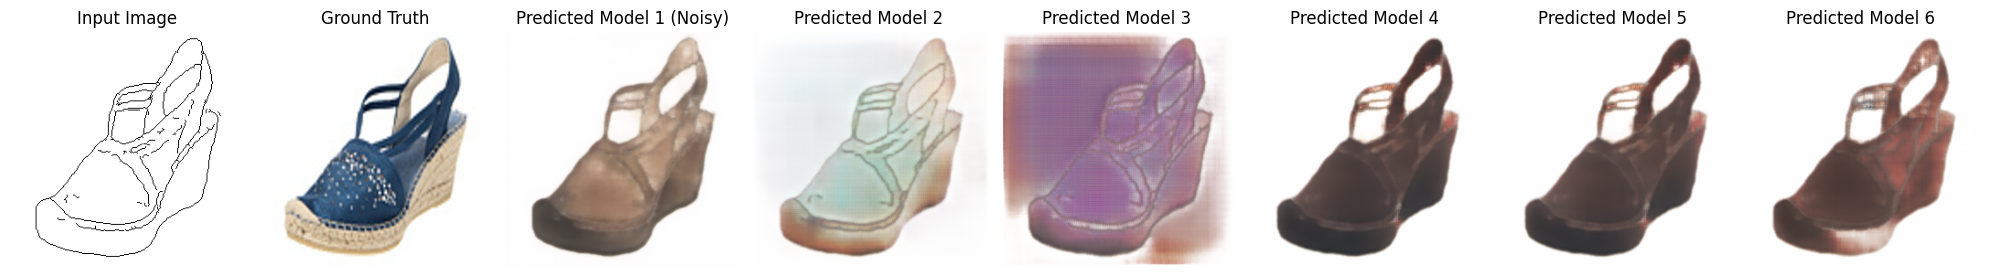

In [12]:
for x_i, y_truth_i in list(zip(X, y_truth))[:16]:
    x_i = np.expand_dims(x_i, axis=0)
    y_pred_all_models = []
    y_pred_need_noise = []

    for gen_model, need_noise in generators_list:
        if need_noise:
            noise_channel = np.random.uniform(-1, 1, size=x_i.shape).astype(np.float32) * 1.0
            x_i_noisy = np.stack([x_i, noise_channel], axis=-1)
        else:
            x_i_noisy = x_i.copy()

        y_pred_i = gen_model.predict(x_i_noisy, verbose=0)
        y_pred_all_models.append(y_pred_i[0])
        y_pred_need_noise.append(need_noise)

    # Here you can add code to visualize or save the predictions

    fig, axs = plt.subplots(1, len(y_pred_all_models) + 2, figsize=(20, 10))

    axs[0].imshow((x_i[0] + 1.0) / 2.0, cmap='gray')
    axs[0].set_title('Input Image')
    axs[0].axis('off')

    axs[1].imshow((y_truth_i + 1.0) / 2.0)
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')

    for i, y_pred_i in enumerate(y_pred_all_models):
        axs[i + 2].imshow((y_pred_i + 1.0) / 2.0)
        axs[i + 2].set_title(f'Predicted Model {i + 1} {"(Noisy)" if y_pred_need_noise[i] else ""}')
        axs[i + 2].axis('off')

    plt.tight_layout()
    plt.show()

# Export Weights Layer by Layer

In [16]:
def save_layer_weights(model, save_dir='layer_weights'):
    os.makedirs(save_dir, exist_ok=True)

    for i, layer in enumerate(model.layers):
        weights = layer.get_weights()
        if weights:
            layer_path = os.path.join(save_dir, f'layer_{i}.npz')
            np.savez(layer_path, *weights)
            print(f"Saved {layer.name} weights to {layer_path}")

save_layer_weights(generators_list[0][0], save_dir= 'deploymeny_code/best_model_layers_weights')

Saved enc_1 weights to deploymeny_code/best_model_layers_weights\layer_1.npz
Saved enc_2 weights to deploymeny_code/best_model_layers_weights\layer_3.npz
Saved batch_normalization weights to deploymeny_code/best_model_layers_weights\layer_4.npz
Saved enc_3 weights to deploymeny_code/best_model_layers_weights\layer_6.npz
Saved batch_normalization_1 weights to deploymeny_code/best_model_layers_weights\layer_7.npz
Saved enc_4 weights to deploymeny_code/best_model_layers_weights\layer_9.npz
Saved batch_normalization_2 weights to deploymeny_code/best_model_layers_weights\layer_10.npz
Saved bottleneck weights to deploymeny_code/best_model_layers_weights\layer_12.npz
Saved batch_normalization_3 weights to deploymeny_code/best_model_layers_weights\layer_13.npz
Saved conv2d weights to deploymeny_code/best_model_layers_weights\layer_15.npz
Saved batch_normalization_4 weights to deploymeny_code/best_model_layers_weights\layer_16.npz
Saved conv2d_1 weights to deploymeny_code/best_model_layers_weig